# Similar supervisor logic to tutorial.ipynb

## Import setup dependencies

In [1]:
import getpass
import os

from rich import print as rprint

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

## Create tools

### Python executor tool

In [2]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# initialise tavily object for tool call later
tavily_tool = TavilySearchResults(max_results = 5)

# initialise PythonREPL object for executing code
repl = PythonREPL()

# uses pythonREPL functionality to run python code generated from the llm output
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to exectue to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed: \n ```python \n{code}\n```\nStdout: {result}"
    return result_str



## Create agent supervisor

In [3]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command

members = ["researcher", "coder"]

# the agent supervisor is supposed to be an LLM node, and is only in charge of picking the next agent to act or 
# deciding when to FINISH

options = members + ["FINISH"]

# prompt to be fed to the agent supervisor
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f"following workes {options}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a task and"
    " respond with their results and status. When finished,"
    " reply with FINISH"
)

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH"""

    # TypedDict restricts the Router class to only have the specified attributes, which in this case is next
    # *options unpacks the options literal to be passed into Literal
    next: Literal[*options]


# initialise ChatOpenAI object which connects the OpenAI API
llm = ChatOpenAI(model="gpt-4o")
# llm = ChatOpenAI()


class State(MessagesState):
    # inherits a list of chat messages from the MessagesState class
    # add a custom attribute called next, which is a string
    next: str

def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:

    # supervisor node takes in the previous states. 
    # generate a new list of messages, containing the previous messages as well as the new system message
    # for the llm to respond to.
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    # invoke a new llm call with the new list of messages, but constraining the output to a dictionary
    # (e.g. {"next" : "FINISH"}) using the with_structured_output method. 
    response = llm.with_structured_output(Router).invoke(messages)

    # extract the next attribute and save it to the variable goto
    goto = response["next"]

    if goto == "FINISH":
        goto = END

    # Command class tells which node to go to next (goto) and stores the decision in the shared state (update).
    return Command(goto = goto, update = {"next": goto})


## Create research agent

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

research_prompt = """You are a researcher. DO NOT do any math."""

# create a response and act agent with the instantiated llm, a list of tools and a prompt
research_agent = create_react_agent(
    llm, tools = [tavily_tool], prompt = research_prompt
)

def research_node(state: State) -> Command[Literal["supervisor"]]:
    # when the research node is provided the shared state, the research_agent defined above takes in the
    # state and responds.
    result = research_agent.invoke(state)

    # Command class tells the research node to update the list of messages with the latest message
    # in the human format with the name researcher. By default state is configured to append any provided
    # messages to an existing array of messages, else it will create a new one.
    # The class also passes the graph control back to the supervisor.
    return Command(
        update = {
            "messages": [
                HumanMessage(content = result["messages"][-1].content, name = "researcher")
            ]
        },
        goto = "supervisor"
    )

## Create code agent

In [ ]:
code_agent = create_react_agent(llm, tools = [python_repl_tool])

def code_node(state: State) -> Command[Literal["supervisor"]]:
    # when the code node is provided the shared state, the code_agent defined above takes in the
    # state and responds.
    result = code_agent.invoke(state)

    # Command class tells the code node to update the list of messages with the latest message
    # in the human format with the name coder. By default state is configured to append any provided
    # messages to an existing array of messages, else it will create a new one.
    # The class also passes the graph control back to the supervisor.
    return Command(
        update = {
            "messages": [
                HumanMessage(content = result["messages"][-1].content, name = "coder")
            ]
        },
        goto = "supervisor"
    )

## Creation and compilation of graph

In [6]:
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)

graph = builder.compile()

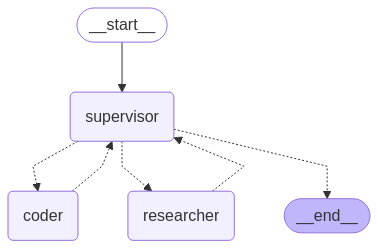

In [7]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## Graph invocation - 1

showcase coder agent

In [8]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs = True
):
    rprint(s)
    print("-------------------------")

((), {'supervisor': {'next': 'coder'}})

-------------------------


Python REPL can execute arbitrary code. Use with caution.


(
    ('coder:4540ca64-2870-04dc-eb13-82d866b6598b',),
    {
        'agent': {
            'messages': [
                AIMessage(
                    content='',
                    additional_kwargs={
                        'tool_calls': [
                            {
                                'id': 'call_LV72nF0LpLYzJoyjegWhEWlb',
                                'function': {
                                    'arguments': '{"code":"import math\\nmath.sqrt(42)"}',
                                    'name': 'python_repl_tool'
                                },
                                'type': 'function'
                            }
                        ],
                        'refusal': None
                    },
                    response_metadata={
                        'token_usage': {
                            'completion_tokens': 24,
                            'prompt_tokens': 98,
                            'total_tokens': 122,
                            'completion_tokens_details': {
                                'accepted_prediction_tokens': 0,
                                'audio_tokens': 0,
                                'reasoning_tokens': 0,
                                'rejected_prediction_tokens': 0
                            },
                            'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                        },
                        'model_name': 'gpt-4o-2024-08-06',
                        'system_fingerprint': 'fp_0011324330',
                        'id': 'chatcmpl-BPv6wgYgKBML1io9EgafSBDQb6mSn',
                        'finish_reason': 'tool_calls',
                        'logprobs': None
                    },
                    id='run-e837feb1-3aec-4e1e-90db-b208cc57b1e1-0',
                    tool_calls=[
                        {
                            'name': 'python_repl_tool',
                            'args': {'code': 'import math\nmath.sqrt(42)'},
                            'id': 'call_LV72nF0LpLYzJoyjegWhEWlb',
                            'type': 'tool_call'
                        }
                    ],
                    usage_metadata={
                        'input_tokens': 98,
                        'output_tokens': 24,
                        'total_tokens': 122,
                        'input_token_details': {'audio': 0, 'cache_read': 0},
                        'output_token_details': {'audio': 0, 'reasoning': 0}
                    }
                )
            ]
        }
    }
)

-------------------------


(
    ('coder:4540ca64-2870-04dc-eb13-82d866b6598b',),
    {
        'tools': {
            'messages': [
                ToolMessage(
                    content='Successfully executed: \n ```python \nimport math\nmath.sqrt(42)\n```\nStdout: ',
                    name='python_repl_tool',
                    id='e461e8e9-74cb-4cf0-bc9c-dcd49e5ed797',
                    tool_call_id='call_LV72nF0LpLYzJoyjegWhEWlb'
                )
            ]
        }
    }
)

-------------------------


(
    ('coder:4540ca64-2870-04dc-eb13-82d866b6598b',),
    {
        'agent': {
            'messages': [
                AIMessage(
                    content='The square root of 42 is approximately 6.48.',
                    additional_kwargs={'refusal': None},
                    response_metadata={
                        'token_usage': {
                            'completion_tokens': 15,
                            'prompt_tokens': 152,
                            'total_tokens': 167,
                            'completion_tokens_details': {
                                'accepted_prediction_tokens': 0,
                                'audio_tokens': 0,
                                'reasoning_tokens': 0,
                                'rejected_prediction_tokens': 0
                            },
                            'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                        },
                        'model_name': 'gpt-4o-2024-08-06',
                        'system_fingerprint': 'fp_0011324330',
                        'id': 'chatcmpl-BPv6ypjXpMxDw0qxQMAndozpH081h',
                        'finish_reason': 'stop',
                        'logprobs': None
                    },
                    id='run-15ef4fd1-3bae-4d6f-8901-82613960d4aa-0',
                    usage_metadata={
                        'input_tokens': 152,
                        'output_tokens': 15,
                        'total_tokens': 167,
                        'input_token_details': {'audio': 0, 'cache_read': 0},
                        'output_token_details': {'audio': 0, 'reasoning': 0}
                    }
                )
            ]
        }
    }
)

-------------------------


(
    (),
    {
        'coder': {
            'messages': [
                HumanMessage(
                    content='The square root of 42 is approximately 6.48.',
                    additional_kwargs={},
                    response_metadata={},
                    name='coder'
                )
            ]
        }
    }
)

-------------------------


((), {'supervisor': {'next': '__end__'}})

-------------------------


## Graph invocation - 2

showcase multi agent workflow: supervisor -> researcher -> supervisor ->  coder

In [9]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    rprint(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})

----


(
    ('researcher:793c26ac-d3e6-7a53-25ce-8c2e7c0c83bf',),
    {
        'agent': {
            'messages': [
                AIMessage(
                    content='',
                    additional_kwargs={
                        'tool_calls': [
                            {
                                'id': 'call_nUKe53gINCrQ5V03Cx7wXBb9',
                                'function': {
                                    'arguments': '{"query": "latest GDP of New York 2023"}',
                                    'name': 'tavily_search_results_json'
                                },
                                'type': 'function'
                            },
                            {
                                'id': 'call_fh0k2SSa0U1TXg8fpQ0jHBcv',
                                'function': {
                                    'arguments': '{"query": "latest GDP of California 2023"}',
                                    'name': 'tavily_search_results_json'
                                },
                                'type': 'function'
                            }
                        ],
                        'refusal': None
                    },
                    response_metadata={
                        'token_usage': {
                            'completion_tokens': 66,
                            'prompt_tokens': 104,
                            'total_tokens': 170,
                            'completion_tokens_details': {
                                'accepted_prediction_tokens': 0,
                                'audio_tokens': 0,
                                'reasoning_tokens': 0,
                                'rejected_prediction_tokens': 0
                            },
                            'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                        },
                        'model_name': 'gpt-4o-2024-08-06',
                        'system_fingerprint': 'fp_55d88aaf2f',
                        'id': 'chatcmpl-BPv70KrMU0cBCQeybCdWgnPsvB88J',
                        'finish_reason': 'tool_calls',
                        'logprobs': None
                    },
                    id='run-8317a030-b260-4742-b8c2-f1cf825a62c5-0',
                    tool_calls=[
                        {
                            'name': 'tavily_search_results_json',
                            'args': {'query': 'latest GDP of New York 2023'},
                            'id': 'call_nUKe53gINCrQ5V03Cx7wXBb9',
                            'type': 'tool_call'
                        },
                        {
                            'name': 'tavily_search_results_json',
                            'args': {'query': 'latest GDP of California 2023'},
                            'id': 'call_fh0k2SSa0U1TXg8fpQ0jHBcv',
                            'type': 'tool_call'
                        }
                    ],
                    usage_metadata={
                        'input_tokens': 104,
                        'output_tokens': 66,
                        'total_tokens': 170,
                        'input_token_details': {'audio': 0, 'cache_read': 0},
                        'output_token_details': {'audio': 0, 'reasoning': 0}
                    }
                )
            ]
        }
    }
)

----


(
    ('researcher:793c26ac-d3e6-7a53-25ce-8c2e7c0c83bf',),
    {
        'tools': {
            'messages': [
                ToolMessage(
                    content='[{"title": "Real GDP New York U.S. 2023 - Statista", "url": 
"https://www.statista.com/statistics/188087/gdp-of-the-us-federal-state-of-new-york-since-1997/", "content": "In 
2023, the real gross domestic product (GDP) of New York was about 1.78 trillion U.S. dollars. This is a slight 
increase from the previous", "score": 0.8785752}, {"title": "What is the gross domestic product (GDP) in New York? 
- USAFacts", "url": "https://usafacts.org/answers/what-is-the-gross-domestic-product-gdp/state/new-york/", 
"content": "In 2023, GDP per person in New York was $90,752, up 1.3% from 2022. In 2023, real GDP was equivalent to
$90,752 per person. Real gross", "score": 0.8747745}, {"title": "Economy of New York City - Wikipedia", "url": 
"https://en.wikipedia.org/wiki/Economy_of_New_York_City", "content": "GDP\\n\\nIn 2023, the GDP of New York City 
was around $1.286 trillion, of which $939 billion, or 73%, was Manhattan.[15]\\n\\nCounty | GDP\\nNew York | 
$938.995 billion\\nKings | $135.980 billion\\nQueens | $133.874 billion\\nBronx | $54.591 billion\\nRichmond | 
$22.298 billion\\nNew York City | $1,285.738 billion\\nCity economic overview [...] The economy of New York City 
encompasses the largest municipal and regional economy in the United States. In 2023, the New York City 
Metropolitan Area generated a GMP of US$2.299 trillion.[5] Anchored by Wall Street in Lower Manhattan, New York 
City has been characterized as the world\'s premier fintech and financial center.[2][6] The city is home to the New
York Stock Exchange (NYSE, on Wall Street) and Nasdaq (headquartered in Times Square), the world\'s two largest 
stock exchanges by both [...] 19 | 21 | 168 | – | Bristol-Myers Squibb | $16.6 | 25,000 | Pharmaceuticals\\n20 | 22
| 174 | – | Colgate-Palmolive | $16.0 | 37,900 | Household and personal products\\n21 | 23 | 179 | – | The Bank of 
New York Mellon | $15.5 | 51,200 | Commercial banks\\n22 | 24 | 184 | – | Icahn Enterprises | $15.3 | 73,807 | 
Diversified financials\\n23 | 25 | 188 | – | Omnicom Group | $15.1 | 74,900 | Advertising, marketing", "score": 
0.8655088}, {"title": "GDP by industry New York U.S. 2023 - Statista", "url": 
"https://www.statista.com/statistics/304883/new-york-real-gdp-by-industry/", "content": "... New York was 82,323 
current U.S. dollars. Read more. Real value added to the gross domestic product of New York in the United States in
2023", "score": 0.8332299}, {"title": "Economy of New York (state) - Wikipedia", "url": 
"https://en.wikipedia.org/wiki/Economy_of_New_York_(state)", "content": "New York City, the economic capital of New
York (state) andthe world\\nStatistics\\nGDP | $2.297 trillion (2024)[1]\\nGDP per capita | $115,619 
(2024)[2]\\nPopulation belowpoverty line | 13.6%[3]\\nGini coefficient | 0.5157 ± 0.0029 (2023)[4]\\nLabour force |
9,645,984 (2023)[5]\\nUnemployment | 4.3% (Feb. 2025)[6]\\nPublic finances\\nRevenues | $63.5 billion[7]\\nExpenses
| $54.6 billion[8] [...] The economy of the State of New York is reflected in its gross state product in 2024 of 
$2.297 trillion, ranking third in size behind the larger states of California and Texas. If New York State were an 
independent nation, it would rank as the 8th largest economy in the world by nominal GDP. However, in 2024, the 
multi-state, New York City-centered metropolitan statistical area produced a gross metropolitan product (GMP) over 
$US2.6 trillion, ranking first nationally by a wide margin and also [...] 49 | 475 | * | ABM Industries | New York 
| 127,000 | $7,807 | Diversified Outsourcing Services | 4th\\n50 | 496 | * | KKR | New York | 4,150 | $7,273 | 
Securities | 9th\\n* = not amongFortune\'s Global 500Sources:Fortune, Volume 183, Number 3 (June/July 2023) and  
Volume 184, Number 1 (August/September 2023);Fortunewebsite;50pros.com\\nSee also", "scor

----


(
    ('researcher:793c26ac-d3e6-7a53-25ce-8c2e7c0c83bf',),
    {
        'agent': {
            'messages': [
                AIMessage(
                    content='The latest GDP figures for 2023 are as follows:\n- New York: Approximately $1.78 
trillion.\n- California: Approximately $3.9 trillion.\n\nWith these figures, you now have the data needed to 
calculate the average GDP of New York and California.',
                    additional_kwargs={'refusal': None},
                    response_metadata={
                        'token_usage': {
                            'completion_tokens': 56,
                            'prompt_tokens': 1850,
                            'total_tokens': 1906,
                            'completion_tokens_details': {
                                'accepted_prediction_tokens': 0,
                                'audio_tokens': 0,
                                'reasoning_tokens': 0,
                                'rejected_prediction_tokens': 0
                            },
                            'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                        },
                        'model_name': 'gpt-4o-2024-08-06',
                        'system_fingerprint': 'fp_55d88aaf2f',
                        'id': 'chatcmpl-BPv76QV6CMbzYV267JPg0egz9idXG',
                        'finish_reason': 'stop',
                        'logprobs': None
                    },
                    id='run-aa0cbce9-54e8-4dd6-b38d-1b29951fb7f7-0',
                    usage_metadata={
                        'input_tokens': 1850,
                        'output_tokens': 56,
                        'total_tokens': 1906,
                        'input_token_details': {'audio': 0, 'cache_read': 0},
                        'output_token_details': {'audio': 0, 'reasoning': 0}
                    }
                )
            ]
        }
    }
)

----


(
    (),
    {
        'researcher': {
            'messages': [
                HumanMessage(
                    content='The latest GDP figures for 2023 are as follows:\n- New York: Approximately $1.78 
trillion.\n- California: Approximately $3.9 trillion.\n\nWith these figures, you now have the data needed to 
calculate the average GDP of New York and California.',
                    additional_kwargs={},
                    response_metadata={},
                    name='researcher'
                )
            ]
        }
    }
)

----


((), {'supervisor': {'next': 'coder'}})

----


(
    ('coder:ff15f767-a879-68aa-0a10-1b36f6557652',),
    {
        'agent': {
            'messages': [
                AIMessage(
                    content='',
                    additional_kwargs={
                        'tool_calls': [
                            {
                                'id': 'call_YrjxN3nEKm7BscSJRJzoh9J3',
                                'function': {
                                    'arguments': '{"code":"# Given GDP for New York and California\\nny_gdp = 1.78 
# in trillion dollars\\nca_gdp = 3.9   # in trillion dollars\\n\\n# Calculate the average GDP\\naverage_gdp = 
(ny_gdp + ca_gdp) / 2\\naverage_gdp"}',
                                    'name': 'python_repl_tool'
                                },
                                'type': 'function'
                            }
                        ],
                        'refusal': None
                    },
                    response_metadata={
                        'token_usage': {
                            'completion_tokens': 80,
                            'prompt_tokens': 165,
                            'total_tokens': 245,
                            'completion_tokens_details': {
                                'accepted_prediction_tokens': 0,
                                'audio_tokens': 0,
                                'reasoning_tokens': 0,
                                'rejected_prediction_tokens': 0
                            },
                            'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                        },
                        'model_name': 'gpt-4o-2024-08-06',
                        'system_fingerprint': 'fp_0011324330',
                        'id': 'chatcmpl-BPv79EI4dxkSRg0MklbQVnTT0cYOQ',
                        'finish_reason': 'tool_calls',
                        'logprobs': None
                    },
                    id='run-83500816-91a8-4a7c-b202-a220508ce6c5-0',
                    tool_calls=[
                        {
                            'name': 'python_repl_tool',
                            'args': {
                                'code': '# Given GDP for New York and California\nny_gdp = 1.78  # in trillion 
dollars\nca_gdp = 3.9   # in trillion dollars\n\n# Calculate the average GDP\naverage_gdp = (ny_gdp + ca_gdp) / 
2\naverage_gdp'
                            },
                            'id': 'call_YrjxN3nEKm7BscSJRJzoh9J3',
                            'type': 'tool_call'
                        }
                    ],
                    usage_metadata={
                        'input_tokens': 165,
                        'output_tokens': 80,
                        'total_tokens': 245,
                        'input_token_details': {'audio': 0, 'cache_read': 0},
                        'output_token_details': {'audio': 0, 'reasoning': 0}
                    }
                )
            ]
        }
    }
)

----


(
    ('coder:ff15f767-a879-68aa-0a10-1b36f6557652',),
    {
        'tools': {
            'messages': [
                ToolMessage(
                    content='Successfully executed: \n ```python \n# Given GDP for New York and California\nny_gdp 
= 1.78  # in trillion dollars\nca_gdp = 3.9   # in trillion dollars\n\n# Calculate the average GDP\naverage_gdp = 
(ny_gdp + ca_gdp) / 2\naverage_gdp\n```\nStdout: ',
                    name='python_repl_tool',
                    id='d2b0bfd6-3398-4d3a-afdc-cf3beeb0988f',
                    tool_call_id='call_YrjxN3nEKm7BscSJRJzoh9J3'
                )
            ]
        }
    }
)

----


(
    ('coder:ff15f767-a879-68aa-0a10-1b36f6557652',),
    {
        'agent': {
            'messages': [
                AIMessage(
                    content='The average GDP of New York and California is approximately $2.84 trillion.',
                    additional_kwargs={'refusal': None},
                    response_metadata={
                        'token_usage': {
                            'completion_tokens': 18,
                            'prompt_tokens': 331,
                            'total_tokens': 349,
                            'completion_tokens_details': {
                                'accepted_prediction_tokens': 0,
                                'audio_tokens': 0,
                                'reasoning_tokens': 0,
                                'rejected_prediction_tokens': 0
                            },
                            'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                        },
                        'model_name': 'gpt-4o-2024-08-06',
                        'system_fingerprint': 'fp_0011324330',
                        'id': 'chatcmpl-BPv7BKhDTfShpGSUBw2MQuENsuh6y',
                        'finish_reason': 'stop',
                        'logprobs': None
                    },
                    id='run-d0010b00-787e-4385-bc5e-17a8f205b72c-0',
                    usage_metadata={
                        'input_tokens': 331,
                        'output_tokens': 18,
                        'total_tokens': 349,
                        'input_token_details': {'audio': 0, 'cache_read': 0},
                        'output_token_details': {'audio': 0, 'reasoning': 0}
                    }
                )
            ]
        }
    }
)

----


(
    (),
    {
        'coder': {
            'messages': [
                HumanMessage(
                    content='The average GDP of New York and California is approximately $2.84 trillion.',
                    additional_kwargs={},
                    response_metadata={},
                    name='coder'
                )
            ]
        }
    }
)

----


((), {'supervisor': {'next': '__end__'}})

----
